<a href="https://colab.research.google.com/github/Ari-Net/ISPPR-2/blob/master/Lab3_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Підключаємо бібліотеки

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 706kB 6.0MB/s 


Завантажуємо набір даних "Chest-xray-pneumonia"

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
train_path='/content/drive/MyDrive/dataset/train/'
valid_path='/content/drive/MyDrive/dataset/val/'
test_path='/content/drive/MyDrive/dataset/test/'
batch_size = 16
img_height = 500
img_width = 500
image_gen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,          
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

In [8]:
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False, 
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem 
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
      valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary', 
      batch_size=batch_size
      )

Found 5256 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


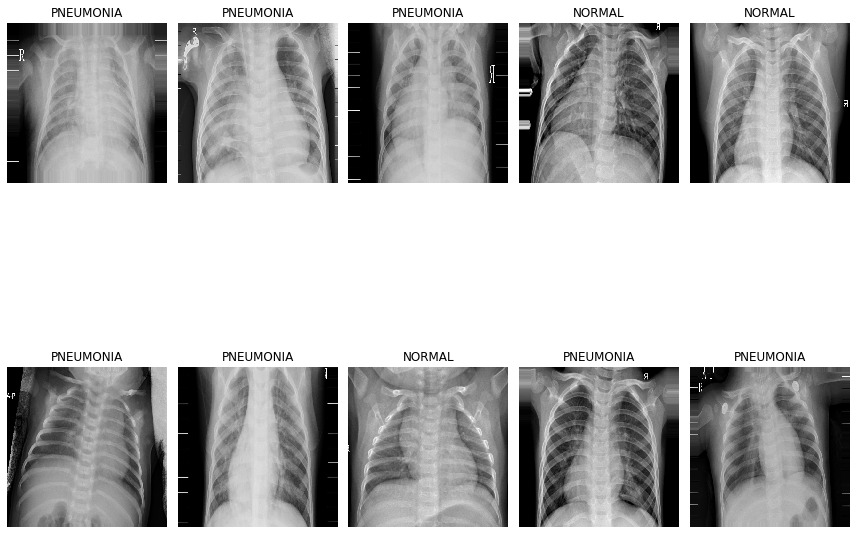

In [9]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]        
        dic = {0:'NORMAL', 1:'PNEUMONIA'}
        plt.title(dic.get(Y_batch[0]))
        plt.axis('off')
        plt.imshow(np.squeeze(image),cmap='gray',interpolation='nearest')
        break
plt.tight_layout()
plt.show()

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau, TensorBoard
%load_ext tensorboard
from tensorflow_addons.metrics import F1Score
import sklearn

In [11]:
alexnet1 = Sequential()
alexnet1.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
alexnet1.add(MaxPooling2D(pool_size = (2, 2)))
alexnet1.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
alexnet1.add(MaxPooling2D(pool_size = (2, 2)))
alexnet1.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
alexnet1.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
alexnet1.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
alexnet1.add(MaxPooling2D(pool_size = (2, 2)))
alexnet1.add(Flatten())
alexnet1.add(Dense(activation = 'relu', units = 128))
alexnet1.add(Dense(activation = 'relu', units = 64))
alexnet1.add(Dense(activation = 'sigmoid', units = 1))
alexnet1.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = [tf.keras.metrics.AUC(name='AUC'),'accuracy', tfa.metrics.F1Score(num_classes=1,name='f1')])
alexnet1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 498, 498, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 249, 249, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 247, 247, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 123, 123, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 121, 121, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 119, 119, 64)      18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 117, 117, 64)      3

In [12]:
# Hyperparameters of Conv2D
Conv2D(filters=32, kernel_size=(3,3), strides=(1,1), padding='valid', activation='relu', input_shape=(500, 500, 1))
# Hyperparameters of MaxPooling2D 
MaxPooling2D(pool_size=(2, 2), strides=(2,2), padding='valid')

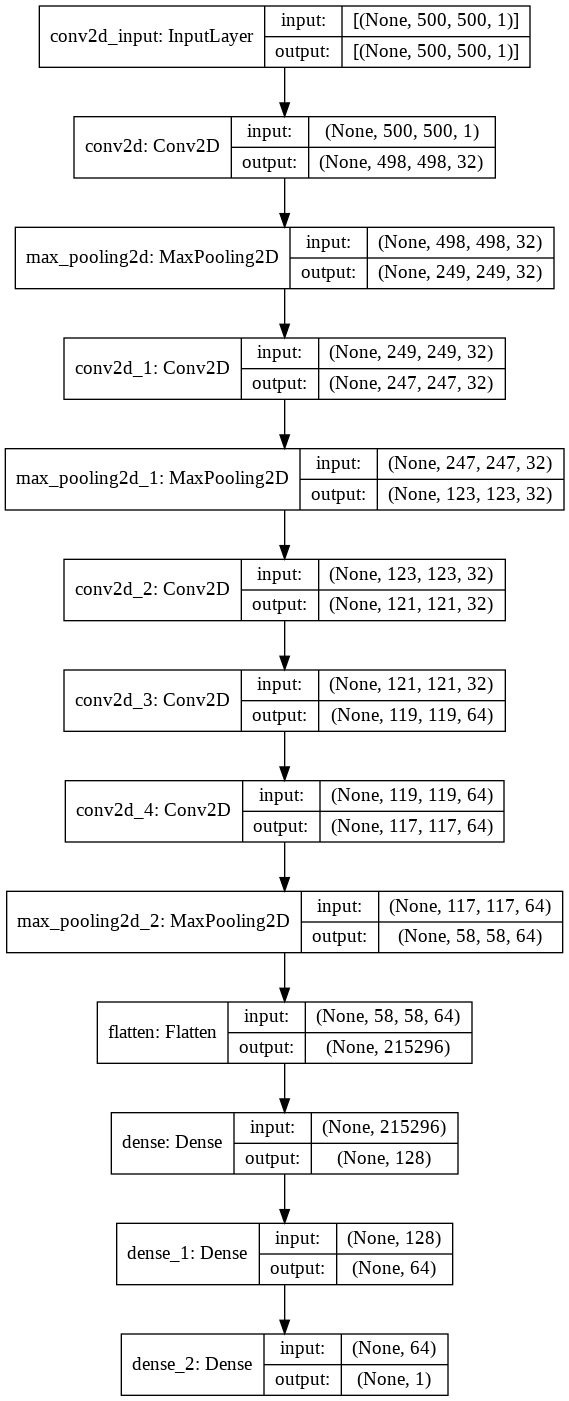

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(alexnet1,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

In [17]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience = 2, verbose=1,factor=0.3, min_lr=0.00001)
callbacks_list = [early, learning_rate_reduction, TensorBoard(log_dir="logs/AlexNet_1/")]

In [18]:
from sklearn.utils.class_weight import compute_class_weight
weights = compute_class_weight('balanced', np.unique(train.classes), train.classes)
cw = dict(zip( np.unique(train.classes), weights))
print(cw)

{0: 1.9452257586972612, 1: 0.6729833546734956}


In [ ]:
alexnet1.fit(train,epochs=10, validation_data=valid, class_weight=cw, callbacks=callbacks_list)

Epoch 1/10
329/329 [==============================] - 2145s 7s/step - loss: 0.4324 - AUC: 0.8924 - accuracy: 0.8179 - f1: 0.8525 - val_loss: 0.5925 - val_AUC: 0.8750 - val_accuracy: 0.6875 - val_f1: 0.6667
Epoch 2/10
329/329 [==============================] - 2058s 6s/step - loss: 0.2871 - AUC: 0.9496 - accuracy: 0.8830 - f1: 0.8525 - val_loss: 0.4187 - val_AUC: 0.9062 - val_accuracy: 0.7500 - val_f1: 0.6667
Epoch 3/10
329/329 [==============================] - 2110s 6s/step - loss: 0.2467 - AUC: 0.9625 - accuracy: 0.9003 - f1: 0.8525 - val_loss: 0.3233 - val_AUC: 0.9453 - val_accuracy: 0.9375 - val_f1: 0.6667
Epoch 4/10
329/329 [==============================] - 2121s 6s/step - loss: 0.2175 - AUC: 0.9704 - accuracy: 0.9104 - f1: 0.8525 - val_loss: 0.6391 - val_AUC: 0.9062 - val_accuracy: 0.8125 - val_f1: 0.6667
Epoch 5/10
329/329 [==============================] - 2071s 6s/step - loss: 0.2035 - AUC: 0.9744 - accuracy: 0.9170 - f1: 0.8525 - val_loss: 0.5518 - val_AUC: 0.9375 - val_accu

In [4]:
pd.Series({k:v[-1] for k, v in history.history.items()})

NameError: ignored

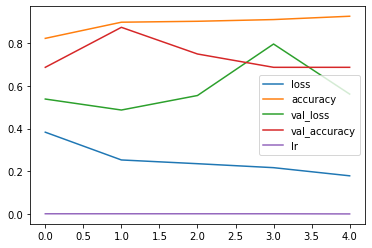

In [ ]:
pd.DataFrame(alexnet1.history.history).plot()

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

39/39 [==============================] - 136s 4s/step - loss: 0.2766 - accuracy: 0.8766
The testing accuracy is : 87.66025900840759 %


In [ ]:
preds = cnn.predict(test,verbose=1)

39/39 [==============================] - 42s 1s/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

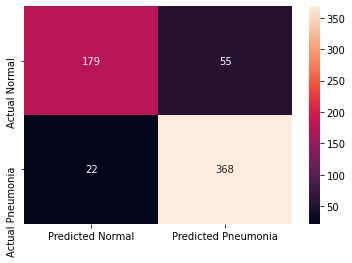

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=["Actual Normal", "Actual Pneumonia"],
columns=["Predicted Normal", "Predicted Pneumonia"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['NORMAL','PNEUMONIA']))

              precision    recall  f1-score   support

      NORMAL       0.89      0.76      0.82       234
   PNEUMONIA       0.87      0.94      0.91       390

    accuracy                           0.88       624
   macro avg       0.88      0.85      0.86       624
weighted avg       0.88      0.88      0.87       624



(624, 500, 500, 1)
(624,)


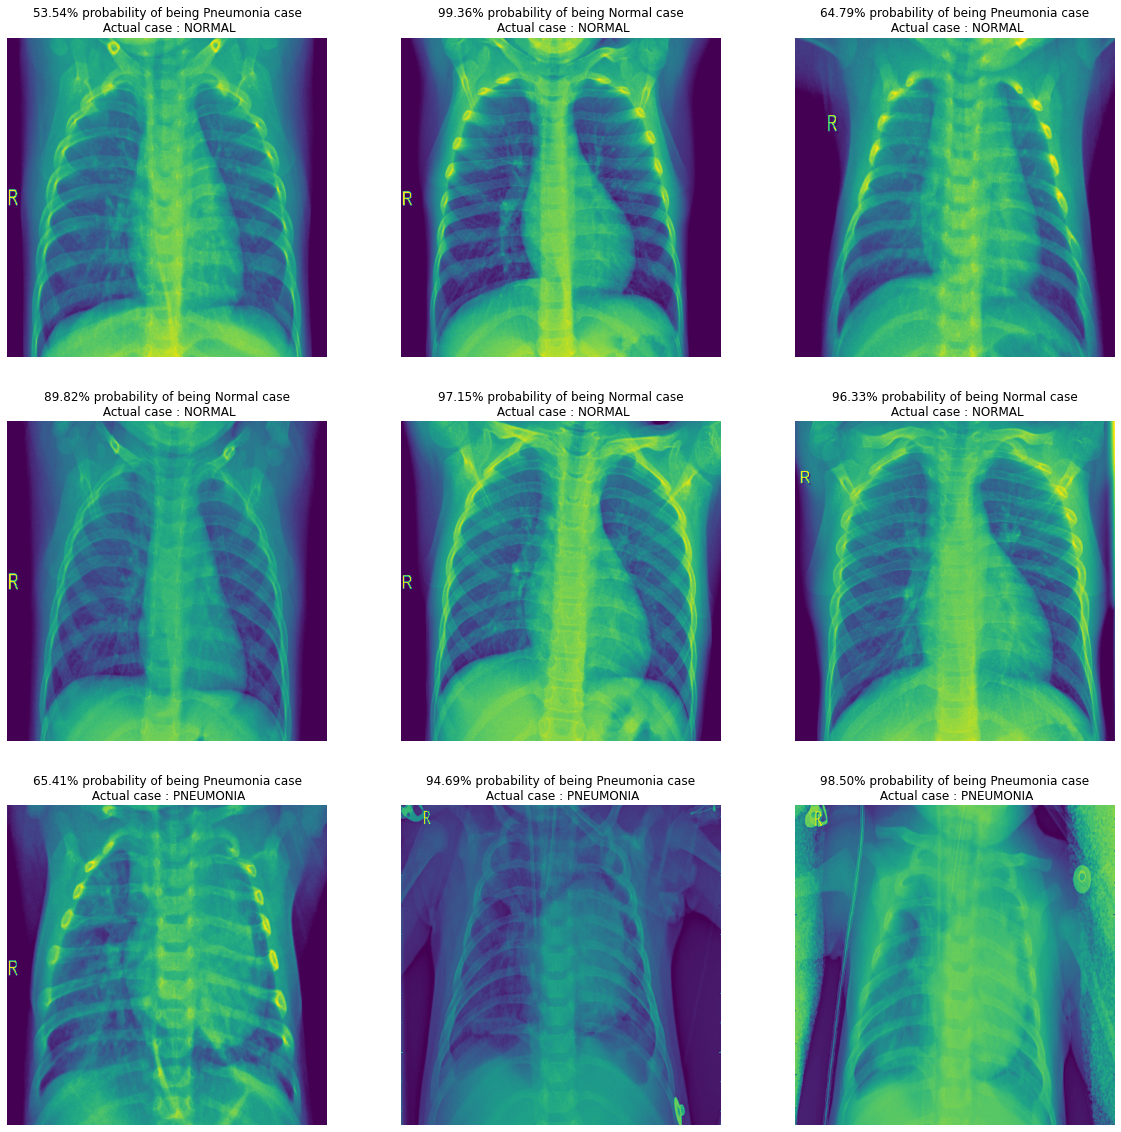

In [ ]:
test.reset()
x=np.concatenate([test.next()[0] for i in range(test.__len__())])
y=np.concatenate([test.next()[1] for i in range(test.__len__())])
print(x.shape)
print(y.shape)
#this little code above extracts the images from test Data iterator without shuffling the sequence
# x contains image array and y has labels 
dic = {0:'NORMAL', 1:'PNEUMONIA'}
plt.figure(figsize=(20,20))
for i in range(0+228, 9+228):
  plt.subplot(3, 3, (i-228)+1)
  if preds[i, 0] >= 0.5: 
      out = ('{:.2%} probability of being Pneumonia case'.format(preds[i][0]))
      
      
  else: 
      out = ('{:.2%} probability of being Normal case'.format(1-preds[i][0]))
  plt.title(out+"\n Actual case : "+ dic.get(y[i]))    
  plt.imshow(np.squeeze(x[i]))
  plt.axis('off')
plt.show()